In [1]:
import pandas as pd
import time
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt

### 1. 데이터 준비

In [2]:
# 데이터 불러오기
adults_icu = pd.read_csv('../outputs/adults_icu2.csv')
intubation_extubation = pd.read_csv('../outputs/intubation_extubation.csv')
# intubation_extubation_stay = pd.read_csv('../outputs/intubation_extubation_stay.csv')

print(f'adults_icu: {adults_icu.shape}')
print(f'intubation_extubation: {intubation_extubation.shape}')
# print(intubation_extubation_stay.shape)

# 시간변수 바꿔주기
intubation_extubation['int_ext_time'] = pd.to_timedelta(intubation_extubation['int_ext_time'])
intubation_extubation['intubationtime'] = pd.to_datetime(intubation_extubation['intubationtime'])
intubation_extubation['extubationtime'] = pd.to_datetime(intubation_extubation['extubationtime'])

intubation_extubation = intubation_extubation.drop(columns=['int_ext_time'])  # int_ext_time 칼럼 필요 X

intubation_extubation.info()

adults_icu: (73181, 13)
intubation_extubation: (10928, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10928 entries, 0 to 10927
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   subject_id       10928 non-null  int64         
 1   hadm_id          10928 non-null  int64         
 2   int_stayid       10928 non-null  int64         
 3   admittime        10928 non-null  object        
 4   intubationtime   10928 non-null  datetime64[ns]
 5   int_itemid       10928 non-null  int64         
 6   int_weight       10928 non-null  float64       
 7   ext_stayid       9387 non-null   float64       
 8   extubationtime   9387 non-null   datetime64[ns]
 9   ext_itemid       9387 non-null   float64       
 10  ext_weight       9387 non-null   float64       
 11  extubationcause  9387 non-null   object        
 12  dischtime        10928 non-null  object        
 13  deathtime        2950 non-null  

### 2. Intubation / Extubation 테이블 전처리
1. Extubation 결측치 처리 (replacement marker 추가)
2. Intubation / Extubation 시간 순서 정렬
3. Intubation to Extubation 시간 차이 계산
4. Reintubation time 계산

#### 작업 함수 정의
- 중요개념
  - 데이터 그룹(group): 전체 데이터프레임은 'subject_id' (환자번호)와 'hadm_id' (입원번호)로 그룹화되어 작업됩니다.
  - 단일 행(single-row) 데이터: 삽관-발관 조합이 **단 하나** 존재하는 데이터 그룹.
  - 연속 행(multi-row) 데이터: 삽관-발관 조합이 **2개 이상** 존재하는 데이터 그룹.

##### 데이터 정리 함수

- **`modify_single_row_df(group)`**
  - 단일 행(single-row) 데이터에만 적용됩니다.
  - 'modify_marker' 열을 추가하고 `None`으로 초기화합니다.

- **`single_row_imputation(group)`**
  - 단일 행(single-row) 데이터에만 적용됩니다.
  - 'extubationtime'이 누락된 경우 'deathtime' 또는 'dischtime'을 기반으로 값을 대체합니다. 'ext_stayid', 'ext_itemid', 'ext_weight'도 동일한 행의 'int_stayid', 'int_itemid', 'int_weight' 값으로 대체합니다.
  - 'modify_marker' 열에 대체 이력이 저장됩니다.
  
- **`find_pairs(unique_intubations, unique_extubations)`**
  - 고유한 삽관(intubation) 시간과 발관(extubation) 시간을 짝지어 주는 함수입니다. 
  - 조건에 따라 적절한 삽관/발관 시간 쌍을 찾아 리스트로 반환합니다.
  - 시간 로직에 적합한 extubationtime 값이 없을 경우, 결측치로 처리합니다.

- **`reformat_multi_row_data_to_dataframe(group, pairs, subject_id, hadm_id)`**
  - 연속 행(multi-row) 데이터에만 적용됩니다.
  - 'modify_marker' 칼럼을 추가하는 등 단일 행 데이터와 동일한 DataFrame 형태로 변환합니다.

- **`multi_row_formatting(group, subject_id, hadm_id)`**
  - 연속 행(multi-row) 데이터에만 적용됩니다.
  - `find_pairs` 함수를 이용해 삽관/발관 이벤트를 시간 로직에 맞게 재구성합니다. 
  - `reformat_multi_row_data_to_dataframe` 함수를 이용해 재정렬된 데이터를 DataFrame으로 변환합니다. 

##### 결측치 처리 함수

- **`impute_non_final_rows(group_df)`**
  - 데이터프레임 내의 마지막 행을 제외한 모든 행에 대해 'extubationtime' 결측치를 다음 행의 'intubationtime'으로 대체합니다.
  - 관련된 다른 열들 (stay_id, itemid, weight)도 함께 업데이트합니다.

- **`impute_final_row(group_df)`**
  - 데이터프레임의 마지막 행에 대해 'extubationtime' 결측치를 'deathtime' 또는 'dischtime'으로 대체합니다. 관련된 다른 열들(stay_id, itemid, weight)도 함께 업데이트합니다.

- **`multi_row_imputation(group_df)`**
  - 다중 행 데이터에 대한 결측치 처리를 수행합니다. `impute_non_final_rows`와 `impute_final_row` 함수를 순차적으로 적용하여 전처리를 진행합니다.

#### 기타 유틸리티 함수

- **`convert_to_datetime(group)`**
  - 주어진 데이터프레임의 'extubationtime', 'deathtime', 'dischtime' 열을 datetime 형식으로 변환합니다. 변환에 실패한 경우 NaT로 처리합니다.

- **`combine_dfs_from_lists(singlerow_data_list, multirow_data_list)`**
  - 단일 행 및 다중 행 데이터 리스트를 결합하여 하나의 데이터프레임으로 변환한 후, 'subject_id', 'hadm_id', 'intubationtime'을 기준으로 정렬합니다.

- **`count_null_extubationtimes(df_list)`**
  - 시간 순서가 재정렬된 데이터 중에서 'extubationtime'의 결측치를 카운트하는 함수입니다. 다양한 유형의 결측치를 분류하여 카운트합니다.

- **`validate_timediff(df_group)`**
  - intubationtime과 extubationtime의 시간차가 타당한지 검증합니다.
  - 만약 intubationtime보다 extubationtime이 더 앞선다면, intubationtime을 admittime(입원시각)으로 대체 가능한지 검증합니다. 
  - admittime으로 대체가능한 경우 대체하고, 대체 불가능한 경우(admittime도 extubationtime보다 앞설 경우) 오류를 마킹하고 넘어갑니다.

- **`get_report(df, original_shape)`**
  - 데이터 전처리 결과를 요약해주는 함수입니다.

#### 재삽관 시간 계산 함수

- **`get_reintubationtime(df)`**
  - 'reintubationtime' 열을 추가하고, 'subject_id'와 'hadm_id'를 기준으로 그룹화하여 각 그룹 내에서 다음 행의 'intubationtime'과 현재 행의 'extubationtime'의 시간 차이를 계산합니다.

#### 메인 함수

- **`process_data(df)`**
  - 전체 데이터 처리 프로세스를 관리하는 메인 함수입니다. 위에 정의된 여러 함수를 호출하여 데이터를 전처리합니다.


In [3]:
##### 결측치 처리, 또는 데이터 검증 관련 로그 코드 #####
modify_error_logs = {
    'deathtime': 'null extubationtime replaced with deathtime',
    'dischtime': 'null extubationtime replaced with dischtime',
    'death_disch_mismatch' : 'deathtime later than dischtime',
    'next_intubationtime' : 'null extubationtime replaced with next intubationtime',
    'int_ext_mismatch' : 'intubationtime later than extubationtime',
    'admittime' : 'replaced intubationtime with admittime'
}

##### 데이터 정리 함수 #####

# 삽관/발관 이벤트가 1쌍 존재하는 그룹의 칼럼 구조 변환 (i.e., 'modify_marker' 칼럼 추가)
def modify_single_row_df(group):
    group['modify_marker'] = None  # 초기화 (결측치 imputation 시 사용될 예정)
    return group


# 삽관/발관 이벤트가 1쌍 존재하는 데이터의 결측치 처리
def single_row_imputation(group):
    # extubationtime 결측치 deathtime, dischtime 값으로 대체
    condition_deathtime = group['extubationtime'].isnull() & group['deathtime'].notnull()
    condition_dischtime = group['extubationtime'].isnull() & group['deathtime'].isnull() & group['dischtime'].notnull()

    group.loc[condition_deathtime, 'extubationtime'] = group.loc[condition_deathtime, 'deathtime']
    group.loc[condition_dischtime, 'extubationtime'] = group.loc[condition_dischtime, 'dischtime']

    # 'ext_stayid', 'ext_itemid', 'ext_weight' 결측치 'int_stayid', 'int_itemid', 'int_weight' 로 대체
    group.loc[condition_deathtime | condition_dischtime, 'ext_stayid'] = group.loc[condition_deathtime | condition_dischtime, 'int_stayid']
    group.loc[condition_deathtime | condition_dischtime, 'ext_itemid'] = group.loc[condition_deathtime | condition_dischtime, 'int_itemid']
    group.loc[condition_deathtime | condition_dischtime, 'ext_weight'] = group.loc[condition_deathtime | condition_dischtime, 'int_weight']

    # modify_marker 칼럼 생성
    group.loc[condition_deathtime, 'modify_marker'] = modify_error_logs['deathtime']
    group.loc[condition_dischtime, 'modify_marker'] = modify_error_logs['dischtime']

    # print(f'modify_error_logs type: {type(group.modify_marker)}')

    return group


# 정렬 알고리즘 v2
def find_pairs(unique_intubations, unique_extubations):
    """
    고유한 삽관 시간과 발관 시간을 쌍으로 짝지어 주는 함수입니다.
        조건 1. 삽관 시간보다 발관 시간이 뒤에 발생해야 함.
        조건 2. 현재 행의 발관 시간이 다음 행의 삽관 시간과 같거나 빨라야 함.

    Args:
    unique_intubations (list): 고유한 삽관 시간의 리스트.
    unique_extubations (list): 고유한 발관 시간의 리스트.

    Returns:
    list: 삽관 시간과 발관 시간이 짝지어진 리스트.
          적절한 발관 시간을 찾지 못할 경우, 발관 시간은 None으로 표시됩니다.
    """

    pairs = []  # 삽관과 발관 시간의 쌍을 저장할 리스트
    ext_index = 0  # 발관 시간 리스트를 탐색하기 위한 인덱스

    # 모든 삽관 시간에 대하여 반복
    for int_index, int_time in enumerate(unique_intubations):
        matched = False  # 현재 삽관 시간에 대한 적절한 발관 시간을 찾았는지 여부

        # 발관 시간 리스트를 순회
        while ext_index < len(unique_extubations) and not matched:
            ext_time = unique_extubations[ext_index]

            # 현재 발관 시간이 삽관 시간보다 늦은지 확인
            if ext_time > int_time:
                # 마지막 삽관 시간인지, 또는 현재 발관 시간이 다음 삽관 시간보다 이른지 확인
                if int_index + 1 == len(unique_intubations) or ext_time < unique_intubations[int_index + 1]:
                    pairs.append((int_time, ext_time))  # 쌍으로 추가
                    matched = True  # 적절한 쌍을 찾음
                else:
                    # 현재 발관 시간이 다음 삽관 시간보다 늦음, 더 이상 진행하지 않음
                    break

            ext_index += 1  # 다음 발관 시간으로 이동

        # 적절한 발관 시간을 찾지 못한 경우
        if not matched:
            pairs.append((int_time, None))  # 삽관 시간과 None을 쌍으로 추가
    
    # # debugging
    # print(f'TESTING find_pairs OUTPUT:')
    # for pair in pairs:
    #     print(f'PAIR: {pair}, TYPE: {type(pair)}')

    return pairs  # 짝지어진 삽관/발관 시간 리스트 반환


# 연속행 데이터의 재구조화
def reformat_multi_row_data_to_dataframe(group, pairs, subject_id, hadm_id):
    formatted_data_list = []

    for pair in pairs:
        intubation_time, extubation_time = pair

        # 칼럼 초기화
        formatted_row_data = {col: None for col in ['subject_id', 'hadm_id', 'int_stayid',
                                        'admittime', 'intubationtime', 'int_itemid', 'int_weight',
                                        'ext_stayid', 'extubationtime', 'ext_itemid', 'ext_weight',
                                        'extubationcause', 'dischtime', 'deathtime', 'modify_marker']}
        
        int_row_cols = ['int_stayid', 'admittime', 'intubationtime', 'int_itemid', 'int_weight', 'dischtime', 'deathtime']
        ext_row_cols = ['ext_stayid', 'extubationtime', 'ext_itemid', 'ext_weight', 'extubationcause']

        # print('========================================================================')
        # print(f'INTUBATION TIME: {intubation_time} --> EXTUBATION TIME: {extubation_time}')
        # print(f'format_multi_row_data ON sub_id: {subject_id}, hadm_id: {hadm_id}...')

        # 삽관/발관시간 필터링
        matching_rows = group[(group['intubationtime'] == intubation_time) & 
                            (group['extubationtime'] == extubation_time)]

        if not matching_rows.empty:
            # Use data from the matching row if available
            matching_data = matching_rows.iloc[0].to_dict()
            formatted_row_data.update(matching_data)
            # print('DETECTED MATCHING ROW.')

        else:
            # intubationtime만 있는 경우 데이터 입력
            if not group[group['intubationtime'] == intubation_time].empty:
                # print(f'DETECTED INTUBATIONTIME: {intubation_time}')
                intubation_data = group[group['intubationtime'] == intubation_time].iloc[0]
                for col in int_row_cols:
                    formatted_row_data[col] = intubation_data[col]

            # extubationtime만 있는 경우 데이터 입력
            if extubation_time is not None and not group[group['extubationtime'] == extubation_time].empty:
                extubation_data = group[group['extubationtime'] == extubation_time].iloc[0]
                for col in ext_row_cols:
                    formatted_row_data[col] = extubation_data[col]
            else:
                # extubationtime이 결측치일 경우, 관련행 None으로 입력
                for col in ext_row_cols:
                    formatted_row_data[col] = None
        
        # 'subject_id', 'hadm_id' 값 입력
        formatted_row_data['subject_id'] = subject_id
        formatted_row_data['hadm_id'] = hadm_id

        # print(f'FORMATTED ROW DATA: {formatted_row_data}, LENGTH: {len(formatted_row_data)}')
        formatted_data_list.append(formatted_row_data)
        # print(f'formatted_data_list: {type(formatted_data_list)}')

    formatted_dataframe = pd.DataFrame(formatted_data_list)   # 재정렬된 dataframe을 반환
    return formatted_dataframe


# 연속행 데이터의 시간대별 재졍렬 및 구조화
def multi_row_formatting(group, subject_id, hadm_id):

    # (subject_id, hadm_id) 그룹 내에서 고유한 intubationtime, extubationtime 값 추출
    unique_intubations = list(group['intubationtime'].dropna().unique())
    unique_extubations = list(group['extubationtime'].dropna().unique())

    # Pairing (sorting algorithm)
    pairs = find_pairs(unique_intubations, unique_extubations)  # result: list of tuples

    # # debugging code
    # print(f'DETECTED {len(pairs)} UNIQUE PAIRS')
    # for i, pair in enumerate(pairs):   # enumerate list
    #     print(f'PAIR {i} ({type(pair)}): {pair}')    # tuple     

    # 재정렬된 데이터 구조화
    reformatted_multirow_dataframe = reformat_multi_row_data_to_dataframe(group, pairs, subject_id, hadm_id)

    return reformatted_multirow_dataframe   # 구조화된 데이터


##### 결측치 처리 함수 #####

# 마지막행을 제외한 행의 결측치 처리
def impute_non_final_rows(group_df):    
    for i in range(len(group_df) - 1):
        # 'extubationtime' null 값 확인
        if pd.isnull(group_df.iloc[i]['extubationtime']):
            # # Debugging: Print values before assignment
            # print(f"Before: Row {i}, ext_itemid: {group_df.at[i, 'ext_itemid']}, ext_weight: {group_df.at[i, 'ext_weight']}")

            # 다음 행의 intubationtime으로 extubationtime 값 대체
            group_df.at[i, 'extubationtime'] = group_df.iloc[i + 1]['intubationtime']
            # 'modify_marker' 업데이트
            group_df.at[i, 'modify_marker'] = modify_error_logs['next_intubationtime']

            # 다음행의 int_stayid, int_itemid, int_weight 값으로 현재 행의 ext_stayid, ext_itemid, ext_weight 값 대체
            group_df.at[i, 'ext_stayid'] = group_df.iloc[i + 1]['int_stayid']
            group_df.at[i, 'ext_itemid'] = group_df.iloc[i + 1]['int_itemid']
            group_df.at[i, 'ext_weight'] = group_df.iloc[i + 1]['int_weight']

            # # Debugging: Print values after assignment
            # print(f"After: Row {i}, ext_itemid: {group_df.at[i, 'ext_itemid']}, ext_weight: {group_df.at[i, 'ext_weight']}")

    return group_df


# 마지막행의 결측치 처리 및 modify_marker 업데이트
def impute_final_row(group_df):
    last_row_idx = len(group_df) - 1
    if pd.isnull(group_df.iloc[last_row_idx]['extubationtime']):
        if pd.notnull(group_df.iloc[last_row_idx]['deathtime']):
            group_df.iloc[last_row_idx, group_df.columns.get_loc('extubationtime')] = group_df.iloc[last_row_idx]['deathtime']
            group_df.iloc[last_row_idx, group_df.columns.get_loc('modify_marker')] = modify_error_logs['deathtime']
        elif pd.notnull(group_df.iloc[last_row_idx]['dischtime']):
            group_df.iloc[last_row_idx, group_df.columns.get_loc('extubationtime')] = group_df.iloc[last_row_idx]['dischtime']
            group_df.iloc[last_row_idx, group_df.columns.get_loc('modify_marker')] = modify_error_logs['dischtime']

        # 이번 행의 int_stayid, int_itemid, int_weight 값으로 같은 행의 ext_stayid, ext_itemid, ext_weight 값 대체
        group_df.iloc[last_row_idx, group_df.columns.get_loc('ext_stayid')] = group_df.iloc[last_row_idx]['int_stayid']
        group_df.iloc[last_row_idx, group_df.columns.get_loc('ext_itemid')] = group_df.iloc[last_row_idx]['int_itemid']
        group_df.iloc[last_row_idx, group_df.columns.get_loc('ext_weight')] = group_df.iloc[last_row_idx]['int_weight']

    return group_df


# 연속행 데이터의 결측치 처리
def multi_row_imputation(group_df):
    # 마지막행을 제외한 데이터 처리
    group_df_non_final_imputed = impute_non_final_rows(group_df)
    # 마지막행 데이터 처리
    preprocessed_group_df = impute_final_row(group_df_non_final_imputed)

    return preprocessed_group_df


##### 기타 유틸리티 함수 #####

def convert_to_datetime(group):
    with warnings.catch_warnings():   
        warnings.simplefilter("ignore")
        # 'intubationtime' datetime 변환
        if group['intubationtime'].dtype != 'datetime64[ns]':
            group['intubationtime'] = pd.to_datetime(group['intubationtime'], errors='coerce')

        # 'extubationtime' datetime 변환
        if group['extubationtime'].dtype != 'datetime64[ns]':
            group['extubationtime'] = pd.to_datetime(group['extubationtime'], errors='coerce')
        
        # 'deathtime' datetime 변환
        if group['deathtime'].dtype != 'datetime64[ns]':
            group['deathtime'] = pd.to_datetime(group['deathtime'], errors='coerce')

        # 'dischtime' datetime 변환
        if group['dischtime'].dtype != 'datetime64[ns]':
            group['dischtime'] = pd.to_datetime(group['dischtime'], errors='coerce')

    return group


def combine_dfs_from_lists(singlerow_data_list, multirow_data_list):
    # 전처리 과정에서 생성된 데이터 리스트를 DataFrame으로 변환
    combined_list = singlerow_data_list + multirow_data_list

    # 복수의 DataFrame을 하나의 DataFrame으로 결합
    combined_df = pd.concat(combined_list, ignore_index=True)

    # 'subject_id', 'hadm_id', 'imputationtime' 순으로 정렬 (ascending=True)
    combined_df = combined_df.sort_values(by=['subject_id', 'hadm_id', 'intubationtime'], ascending=True)

    return combined_df


# Debugging, troubleshooting code
def count_null_extubationtimes(df_list):
    # 시간 순서가 재정렬된 데이터 중에서 결측치를 카운트하는 함수
    # 참고: single row final exttime null과 multi row final exttime null는 같은 로직으로 결측치를 처리함 (deathtime, dischtime 대체)

    # Count 초기화
    null_count_dict = {
        'single row final exttime null': 0,  # 단일 케이스에서 exttime이 결측
        'multi row final exttime null': 0,   # 복수 케이스에서 최종 exttime이 결측
        'multi row middle exttime null': 0   # 복수 케이스에서 중간 exttime이 결측
    }

    for df in df_list:
        # single row 데이터 확인
        if len(df) == 1:
            if pd.isnull(df['extubationtime'].iloc[0]):
                null_count_dict['single row final exttime null'] += 1

        # multi row 데이터 확인
        elif len(df) > 1:
            # 최종 null 값 확인
            if pd.isnull(df['extubationtime'].iloc[-1]):
                null_count_dict['multi row final exttime null'] += 1

            # 중간 null 값 확인
            if df[:-1]['extubationtime'].isnull().any():
                null_count_dict['multi row middle exttime null'] += 1

    return null_count_dict


# intubationtime과 extubationtime의 시간차 검증 코드
def validate_timediff(df):

    # 'subject_id'과 'hadm_id'로 그룹
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    for (subject_id, hadm_id), group in tqdm(grouped_df, desc="\tProcessing Time Diff Validation"):
        # print(f'\tVALIDATING subject_id: {subject_id}, hadm_id: {hadm_id}...')

        # timestamps 데이터타입 변환
        group['admittime'] = pd.to_datetime(group['admittime'], errors='coerce')
        group['extubationtime'] = pd.to_datetime(group['extubationtime'], errors='coerce')
        group['dischtime'] = pd.to_datetime(group['dischtime'], errors='coerce')
        group['deathtime'] = pd.to_datetime(group['deathtime'], errors='coerce')      

        # 삽관/발관 시간 처리
        # 'extubationtime'과 'intubationtime' 시간차 계산
        time_diff = group['extubationtime'] - group['intubationtime']

        # 시간차가 음수인 데이터 확인
        if any(time_diff.dt.total_seconds() < 0):
            # print('NEGATIVE EVENT DETECTED.')
            # 단일행 데이터
            if len(group) == 1:
                # 'extubationtime'이 'admittime'보다 빠른 경우 
                if group['admittime'].iloc[0] < group['extubationtime'].iloc[0]:
                    df.loc[group.index, 'intubationtime'] = group['admittime'].iloc[0]
                    df.at[group.index[0], 'modify_marker'] = modify_error_logs['int_ext_mismatch'], modify_error_logs['admittime']
                    # print('SINGLE ROW EVENT TAKEN CARE OF.')

                # 대체 가능한 값이 없을 때 마커만 기록
                else:
                    df.at[group.index[0], 'modify_marker'] = modify_error_logs['int_ext_mismatch']
            else:
                # 정렬 알고리즘 작동 후에 해당 케이스는 없는게 정상인데.. 만약 있다면 로깅만.
                # print('MULTI ROW EVENT DETECTED. ')
                df.at[group.index[0], 'modify_marker'] = modify_error_logs['int_ext_mismatch']
                pass
        
        # 퇴원/사망 시간 처리
        # 퇴원시간 - 사망시간 시간차 계산
        disch_death_time_diff = group['dischtime'] - group['deathtime']

        # 시간차가 음수인 데이터 확인
        if any(disch_death_time_diff.dt.total_seconds() < 0):
            for i in group.index:
                # 기존의 'modify_marker' 값 확인
                if pd.notna(df.at[i, 'modify_marker']):
                    # 기존 값이 존재할 경우, 새로운 값 추가한 튜플 생성
                    current_marker = df.at[i, 'modify_marker']
                    if isinstance(current_marker, tuple):
                        # 기존값이 튜플일 경우, 새로운 값을 기존 튜플에 추가
                        df.at[i, 'modify_marker'] = current_marker + (modify_error_logs['death_disch_mismatch'],)
                    else:
                        # 기존값이 튜플이 아닐 경우, 새로운 값과 함께 새로운 튜플 생성
                        df.at[i, 'modify_marker'] = (current_marker, modify_error_logs['death_disch_mismatch'])
                else:
                    # 기존값이 없을 경우, 마커 스트링 추가
                    df.at[i, 'modify_marker'] = modify_error_logs['death_disch_mismatch']

    return df


# 결과 리포트하는 함수
def get_report(df, original_shape):

    subject_count =  len(df.subject_id.unique()) # 고유 환자 수
    hadm_count =  len(df.hadm_id.unique()) # 고유 입원 케이스 수

    # 카운터 초기화
    errors = {key: 0 for key in modify_error_logs.keys()}

    # 'modify_marker'가 있는 데이터 확인
    for marker in df[df['modify_marker'].notnull()]['modify_marker']:
        if isinstance(marker, tuple):
            # 마커가 튜플인 경우, 튜플 안의 개별 값을 카운트
            for error in marker:
                for key in modify_error_logs.keys():
                    if modify_error_logs[key] in error:
                        errors[key] += 1
        else:
            # 마커가 개별 스트링인 경우 카운트
            for key in modify_error_logs.keys():
                if modify_error_logs[key] in marker:
                    errors[key] += 1

    total_marker_count = sum(errors.values())   # 전체 마커수 카운트

    # timedelta -> number of days
    reintubation_days = df['reintubationtime'].dt.days
    reintubation_count = (df.reintubationtime.dt.days > 0).sum()

    print('====================================REPORT====================================')
    print(f'ORIGINAL DATA SHAPE: {original_shape}')
    print(f'PROCESSED DATA SHAPE: {df.shape}')
    print(f'NUM UNIQUE SUBJECTS: {subject_count}')
    print(f'NUM UNIQUE HOSPITAL ADMISSIONS: {hadm_count}')
    print(f'NUM REINTUBATION EVENTS: {reintubation_count} / {df.shape[0]} ({round(reintubation_count/df.shape[0] * 100, 2)}%)')
    print(f'NUM DATA ERRORS: {total_marker_count} / {df.shape[0]} ({round(total_marker_count / df.shape[0] * 100, 2)} %)')
    for error_type, count in errors.items():
        print(f"\t{error_type} ERRORS: {count} / {total_marker_count} instances ({round(count/total_marker_count, 2)} %)")


    # 빈도 분포 그래프 (로그변환) 그리기  (0값이 너무 많아서 로그 변환 필요)
    plt.figure(figsize=(10, 6))
    plt.hist(reintubation_days, bins=range(int(reintubation_days.min()), int(reintubation_days.max()) + 2), align='left', color='blue', edgecolor='black', log=True)
    plt.xlabel('Days')
    plt.ylabel('Frequency (Log Scale)')
    plt.title('Frequency Distribution of Reintubation Time (Log Scale)')

    tick_interval = 5  # x tick 간격 설정
    plt.xticks(range(int(reintubation_days.min()), int(reintubation_days.max()) + 1, tick_interval))
    plt.xticks(rotation=45) 

    plt.grid(axis='y', alpha=0.75)
    plt.show()


##### 재삽관 시간 계산 함수 #####

def get_reintubationtime(df):
    # DataFrame을 'subject_id', 'hadm_id', 'intubationtime' 으로 정렬
    df = df.sort_values(by=['subject_id', 'hadm_id', 'intubationtime'])

    # 'reintubationtime' 값을 0으로 초기화
    df['reintubationtime'] = pd.Timedelta(seconds=0)

    # 'subject_id'과 'hadm_id'으로 그룹
    grouped = df.groupby(['subject_id', 'hadm_id'])

    # 개별 그룹 순회
    for name, group in grouped:
        # 1째 행과 마지막행을 제외한 행의 reintubation 값 계산
        if len(group) > 2:
            for i in range(1, len(group) - 1):
                current_idx = group.index[i]
                next_idx = group.index[i + 1]

                # 'reintubationtime' 계산
                df.at[current_idx, 'reintubationtime'] = df.at[next_idx, 'intubationtime'] - df.at[current_idx, 'extubationtime']

    reintubation_df = df.reset_index(drop=True)

    return reintubation_df


##### 메인 함수 #####

def process_data(df):
    original_shape = df.shape
    start_time = time.time()   # 소요시간 계산
    print('DATA PROCESSING...')

    # 'int_ext_time' column 확인 후 삭제
    if 'int_ext_time' in df.columns:
        df = df.drop('int_ext_time', axis=1)

    # subject_id와 hadm_id로 그룹화
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    preprocessed_single_row_list = []
    reformatted_multirow_dataframe_list = []

    # 데이터 1차 정리: single row processing, multirow reformatting
    for (subject_id, hadm_id), group in tqdm(grouped_df, desc="\tProcessing Groups"):
        # print(f'\tPROCESSING subject_id: {subject_id}, hadm_id: {hadm_id}...')

        # 시간변수 Datetime 변환 (확실히 하기 위해)
        group = convert_to_datetime(group)

        # single row processing
        # 해당 그룹(hadm_id)에 intubation 이벤트가 하나만 있는 경우 (즉, 순서 검증이 필요 없는 경우)
        if group['intubationtime'].count() == 1:
            modified_single_row = modify_single_row_df(group) # 'modify_marker' 추가
            imputed_single_row_group = single_row_imputation(modified_single_row)  # 결측치 처리 후 마킹
            preprocessed_single_row_list.append(imputed_single_row_group)

        # 해당 그룹(hadm_id) 안에 여러 개의 intubation 이벤트가 있는 경우 (즉, 순서 검증이 필요한 경우)
        elif group['intubationtime'].count() > 1:

            # multi-row pairing, dataframe formatting
            reformatted_multirow_dataframe = multi_row_formatting(group, subject_id, hadm_id)
            reformatted_multirow_dataframe_list.append(reformatted_multirow_dataframe)  # list of dfs


    # 데이터 2차 정리: reformatted multirow data 처리
    ## 1) 새로 발생한 single_row 처리
    ## 2) multirow 결측치 처리
            
    preprocessed_multirow_data_list = []
    for group_df in tqdm(reformatted_multirow_dataframe_list, desc="\tProcessing Multi-Row Data"):
        # 정리된 DataFrame 중에도 single row event 가 존재할 수 있음. 
        ## 이 경우, 똑같이 single_row_imputation을 사용.
        if group_df['intubationtime'].count() == 1:
            imputed_single_row_df = single_row_imputation(group_df)
            preprocessed_single_row_list.append(imputed_single_row_df)
        
        else:
            imputed_multi_row_df = multi_row_imputation(group_df)
            preprocessed_multirow_data_list.append(imputed_multi_row_df)

    # 전처리 완료된 데이터프레임 결합
    preprocessed_df = combine_dfs_from_lists(preprocessed_single_row_list, preprocessed_multirow_data_list)
    print('\tPREPROCESSING COMPLETE.')

    # intubation/extubation 시간차 검증
    print('\tRUNNING TIME DIFF VALIDATION...')
    validated_df = validate_timediff(preprocessed_df)
    print('\tVALIDATION COMPLETE.')


    # extubation - intubation 시간차 계산
    validated_df['intubationtime'] = pd.to_datetime(validated_df['intubationtime'], errors='coerce')
    validated_df['extubationtime'] = pd.to_datetime(validated_df['extubationtime'], errors='coerce')
    validated_df['int_ext_timediff'] = validated_df['extubationtime'] - validated_df['intubationtime']

    # reintubationtime 계산
    print('\tCOMPUTING reintubationtime...')
    reintubation_df = get_reintubationtime(validated_df)

    print('PROCESSING COMPLETE.')

    # 전처리 리포트 출력
    get_report(reintubation_df, original_shape)

    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))


    return reintubation_df



    



DATA PROCESSING...


	Processing Multi-Row Data: 100%|██████████| 1741/1741 [00:01<00:00, 1205.96it/s]


	PREPROCESSING COMPLETE.
	RUNNING TIME DIFF VALIDATION...


	Processing Time Diff Validation: 100%|██████████| 7087/7087 [00:05<00:00, 1194.22it/s]


	VALIDATION COMPLETE.
	COMPUTING reintubationtime...
PROCESSING COMPLETE.
====================================REPORT====================================
ORIGINAL DATA SHAPE: (10928, 14)
PROCESSED DATA SHAPE: (8232, 17)
NUM UNIQUE SUBJECTS: 6709
NUM UNIQUE HOSPITAL ADMISSIONS: 7087
NUM REINTUBATION EVENTS: 84 / 8232 (1.02%)
NUM DATA ERRORS: 3085 / 8232 (37.48 %)
	deathtime ERRORS: 862 / 3085 instances (0.28 %)
	dischtime ERRORS: 1075 / 3085 instances (0.35 %)
	death_disch_mismatch ERRORS: 133 / 3085 instances (0.04 %)
	next_intubationtime ERRORS: 229 / 3085 instances (0.07 %)
	int_ext_mismatch ERRORS: 394 / 3085 instances (0.13 %)
	admittime ERRORS: 392 / 3085 instances (0.13 %)


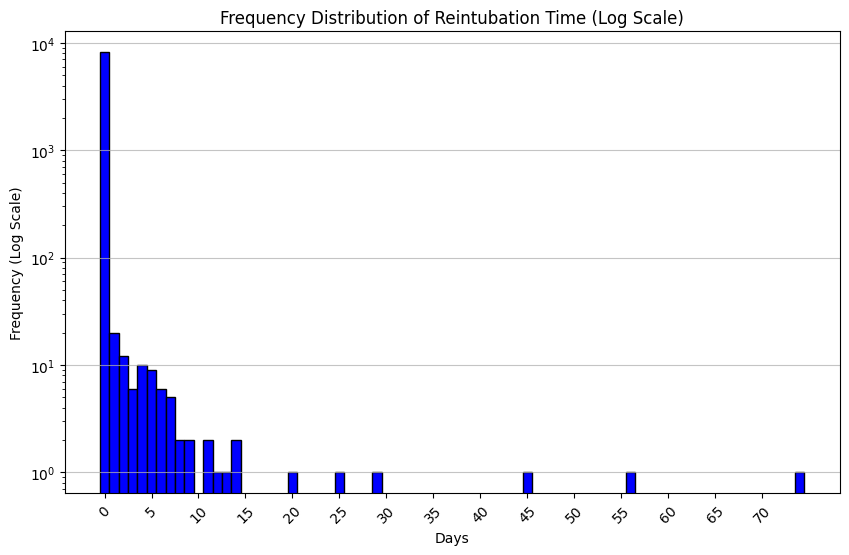

--- RUNTIME: 23.48 seconds ---


In [4]:
reintubation_df_full = process_data(intubation_extubation)


In [5]:
reintubation_df_full.to_csv('../outputs/reintubation_df_full.csv')